In [1]:
import sionna.rt
import xarray as xr
import time
import tensorflow as tf
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import yaml
from sionna.rt import load_scene, AntennaArray, PlanarArray, Transmitter, Receiver, Camera,\
                      PathSolver, RadioMapSolver, subcarrier_frequencies, SceneObject, RadioMaterial
from sionna.rt.scene import simple_reflector, box_two_screens, triple_reflector
print("Sionna version:", sionna.rt.__version__)
print("tf version:", tf.__version__)

2025-09-30 14:00:39.806541: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759240839.858980  320315 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759240839.875770  320315 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1759240839.914208  320315 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1759240839.914235  320315 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1759240839.914239  320315 computation_placer.cc:177] computation placer alr

Sionna version: 1.0.2
tf version: 2.19.0


In [2]:
# select GPU if available
gpus = tf.config.list_physical_devices('GPU')
print("GPU:", gpus)

if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.set_visible_devices(gpus[0], 'GPU') # only use the first GPU
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    print("Using GPU:", gpus[0].name)
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

else:
  print("No GPU found, using CPU.")



GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
2 Physical GPUs, 1 Logical GPU
Using GPU: /physical_device:GPU:0


I0000 00:00:1759240845.137553  320315 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 12109 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:01:00.0, compute capability: 7.5


## Loading and editing the scene

In [3]:
# Load scene
#scene = load_scene(r"/home/user/6GTandem_RT_server/6G_Tandem_kantoorruimte_v10/office_space.xml") 

scene = load_scene(triple_reflector, merge_shapes=False)


In [4]:

# print name of all objects in the scene
print(scene.objects.keys())

# adjust the position of the large reflector
reflector_height = 3 # meters
scene.objects['large_reflector'].position = [0, 0, reflector_height]
print(f"reflector height set to {scene.objects['large_reflector'].position}")

# move small reflector cause not needed
scene.objects['small_reflector'].position = [0, 0, -0.1]


# load config file
N_antennas = 1
pattern = "tr38901"
tx_height = 0.6
rx_height = tx_height
polarization = "V"
scene.tx_array = PlanarArray(num_rows=N_antennas,
                                num_cols=N_antennas,
                                vertical_spacing=0.5,
                                horizontal_spacing=0.5,
                                pattern=pattern,
                                polarization=polarization)

# Configure antenna array for all receivers
scene.rx_array = PlanarArray(num_rows=N_antennas,
                            num_cols=N_antennas,
                            vertical_spacing=0.5,
                            horizontal_spacing=0.5,
                            pattern=pattern,
                            polarization=polarization)
                            # Create transmitter

tx = Transmitter(name="tx",
                 position=[0, 0, tx_height],
                 display_radius=0.5)

# Add transmitter instance to scene
scene.add(tx)

# Create a receiver
rx = Receiver(name="rx",
              position=[0, 0.01, rx_height],
              display_radius=0.5)

# Add receiver instance to scene
scene.add(rx)

tx.look_at([0,0,3]) # Transmitter points up
rx.look_at([0,0.01,3]) # Receiver points up

dict_keys(['floor', 'small_reflector', 'large_reflector'])
reflector height set to [[0, 0, 3]]


In [5]:
# change radio materials to work above 100 GHz
def ituf_metal_callback(f_hz):
  f_ghz = f_hz / 1e9
  relative_permittivity = 1.0  
  c, d = 10**7, 0.0
  conductivity = c*np.power(f_ghz, d)
  return (relative_permittivity, conductivity)

# update materials in the scene
floor = scene.get("floor")
floor.radio_material.frequency_update_callback = ituf_metal_callback
print(floor.radio_material.name)
print(floor.radio_material.frequency_update_callback)

large_reflector = scene.get("large_reflector")
large_reflector.radio_material.frequency_update_callback = ituf_metal_callback
print(large_reflector.radio_material.name)
print(large_reflector.radio_material.frequency_update_callback)

small_reflector = scene.get("small_reflector")
small_reflector.radio_material.frequency_update_callback = ituf_metal_callback
print(small_reflector.radio_material.name)
print(small_reflector.radio_material.frequency_update_callback)


itu_metal
<function ituf_metal_callback at 0x79ad4e3c5440>
itu_metal
<function ituf_metal_callback at 0x79ad4e3c5440>
itu_metal
<function ituf_metal_callback at 0x79ad4e3c5440>


In [6]:
scene.preview(); # open interactive window to preview the scene

## Check radiation patterns


(<Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 2 Axes>)

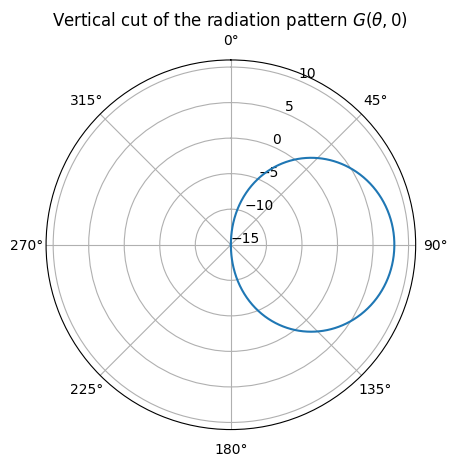

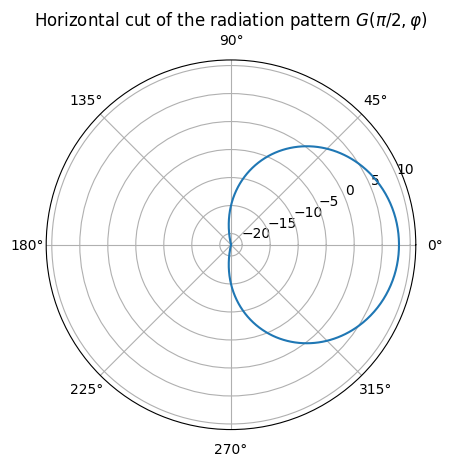

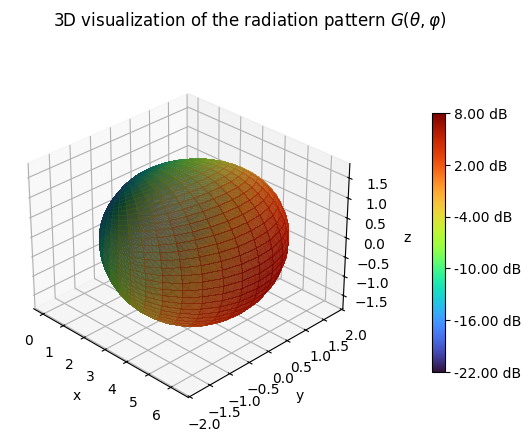

In [7]:
scene.tx_array.antenna_pattern.show()


## run the path solver

In [8]:


# OFDM system parameters
BW = 12.5e+9
num_subcarriers = 1024
subcarrier_spacing = BW / num_subcarriers
frequencies = subcarrier_frequencies(num_subcarriers, subcarrier_spacing) # Compute baseband frequencies of subcarriers relative to the carrier frequency

# set scene frequency
scene.frequency = 157.75e+9# Set frequency to fc 

# Instantiate a path solver
p_solver  = PathSolver()

# compute the paths
paths = p_solver(scene=scene,
                max_depth=20,
                los=True,
                specular_reflection=True,
                diffuse_reflection=False, # no scattering
                refraction=True,
                synthetic_array=False,
                seed=41)



Shape of h_freq:  (1, 1, 1, 1, 1, 1024)
Shape of h_freq reshaped:  (1024,)


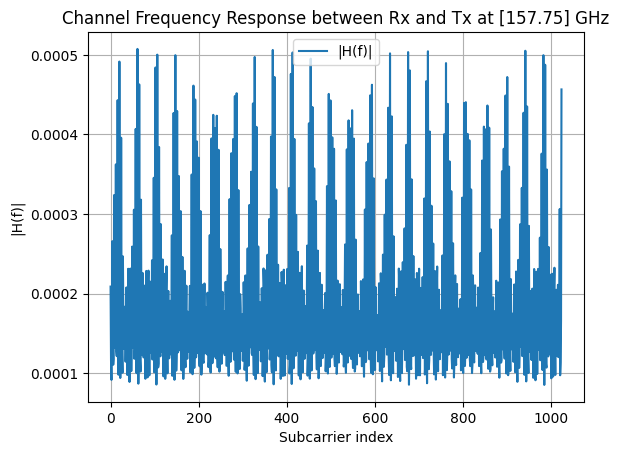

In [9]:
# Compute channel frequency response
# Shape: [num_rx, num_rx_ant, num_tx, num_tx_ant, num_time_steps, num_subcarriers]
h_freq = paths.cfr(frequencies=frequencies,
                    normalize_delays=True,
                    out_type="numpy")
print("Shape of h_freq: ", h_freq.shape)

# reshape to [nr_rx_antennas, nr_tx_antennas, nr_subcarriers]
h_freq = np.squeeze(h_freq)
print("Shape of h_freq reshaped: ", h_freq.shape)

# plot
plt.plot(np.abs(h_freq[:]), label='|H(f)|')
plt.xlabel('Subcarrier index')
plt.ylabel('|H(f)|')
plt.title(f'Channel Frequency Response between Rx and Tx at {scene.frequency/1e9} GHz')
plt.grid()
plt.legend()           
plt.show()

a shape: (1, 1, 1, 1, 40, 1), tau shape: (1, 1, 1, 1, 40)
[  4.0029078  16.011112   20.013872   20.013874   24.016636   36.02494
  40.027706   40.027706   44.03047    56.038776   60.041546   60.041546
  64.04432    76.05262    80.05538    80.05539    84.05815    96.06646
 100.06923   100.06923   104.07201   116.080315  120.08308   120.08308
 124.08583   136.09416   140.09692   140.09692   144.09967   156.108
 160.11076   160.11076   164.11353   176.12186   180.1246    180.1246
 184.12738   196.1357    200.13846   200.13846  ]
[6.3048500e-10 3.9413368e-11 2.5157778e-08 2.5158076e-14 1.7424603e-11
 7.7442896e-12 6.2562857e-15 6.2562666e-09 5.1567990e-12 3.1835368e-12
 2.7658777e-15 2.7658744e-09 2.4245128e-12 1.7193223e-12 1.5475803e-15
 1.5475807e-09 1.3999894e-12 1.0718672e-12 9.8521757e-10 9.8521695e-16
 9.0847767e-13 7.3023971e-13 6.8056299e-10 6.8056334e-16 6.3567776e-13
 5.2844664e-13 4.9736149e-10 4.9736118e-16 4.6886968e-13 3.9951053e-13
 3.7877768e-16 3.7877954e-10 3.5957294e-13

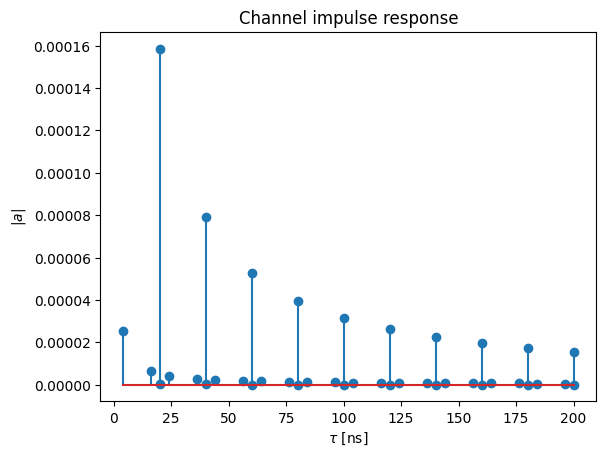

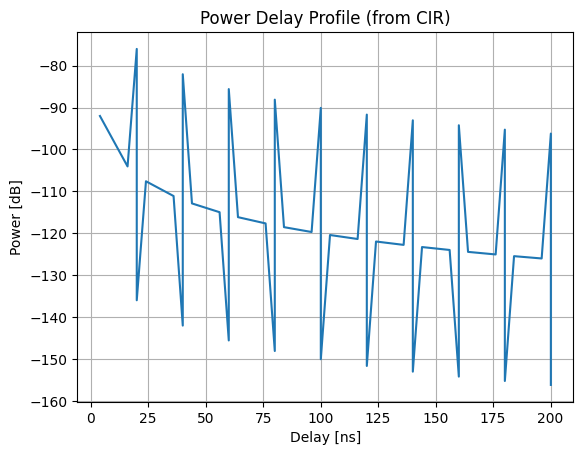

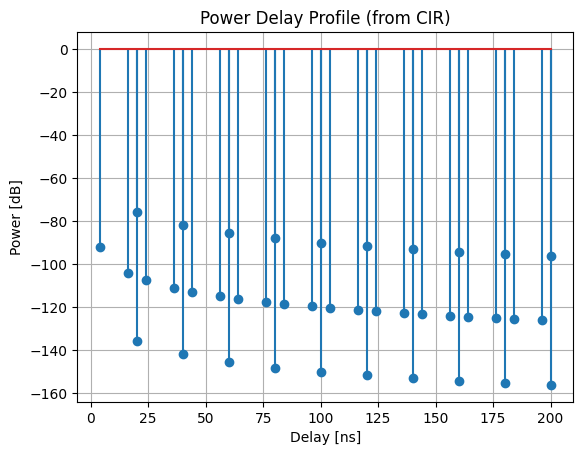

In [15]:
a, tau = paths.cir(normalize_delays=False, out_type="numpy")
print(f'a shape: {a.shape}, tau shape: {tau.shape}')

t = np.squeeze(tau)/1e-9 # Scale to ns
a_abs = np.abs(np.squeeze(a))
a_max = np.max(a_abs)

# And plot the CIR
plt.figure()
plt.title("Channel impulse response")
plt.stem(t, a_abs)
plt.xlabel(r"$\tau$ [ns]")
plt.ylabel(r"$|a|$");


power = np.abs(np.squeeze(a))**2   # path power
# Sort by delay
sort_idx = np.argsort(t)
t_sorted = t[sort_idx]
power_sorted = power[sort_idx]
print(t_sorted)
print(power_sorted)
plt.figure()
plt.plot(t_sorted, 10*np.log10(power_sorted))
plt.xlabel("Delay [ns]")
plt.ylabel("Power [dB]")
plt.title("Power Delay Profile (from CIR)")
plt.grid(True)
plt.show()


plt.figure()
plt.stem(t, 10*np.log10(power))
plt.xlabel("Delay [ns]")
plt.ylabel("Power [dB]")
plt.title("Power Delay Profile (from CIR)")
plt.grid(True)
plt.show()

In [11]:
# preview with the paths
scene.preview(paths=paths)

Renderer(camera=PerspectiveCamera(aspect=1.31, children=(DirectionalLight(intensity=0.25, matrixWorldNeedsUpda…